In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import PIL.Image as Image
import torch.nn as nn
import torchvision
import torch.optim as optim
import sys
from captum.attr import GuidedGradCam
import cv2
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz

sys.path.insert(0, '../src')
from bird_dataset import *
from XAI_birds_dataloader import *
from tqdm import tqdm
from models.multi_task_model import *
from XAI_birds_dataloader import *
from XAI_BirdAttribute_dataloader import *

In [2]:
bd = BirdDataset(preload=True, attr_file='attributes-subset')

In [3]:
# bd.attributes

In [5]:
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_bird_dataset = Bird_Attribute_Loader(bd, attrs=['has_bill_shape', 'has_wing_color'], species=True, transform=trans, train=True, val=False)
val_bird_dataset = Bird_Attribute_Loader(bd, attrs=['has_bill_shape', 'has_wing_color'], transform=trans, train=False, val=True)

In [11]:
# bd.images

In [14]:
bd

In [15]:
train_bird_dataset.images

[{'filepath': '188.Pileated_Woodpecker/Pileated_Woodpecker_0091_180343.jpg',
  'class_label': 188,
  'bounding_box': [174.0, 72.0, 137.0, 258.0],
  'parts': {'back': [223.0, 147.0],
   'beak': [287.0, 86.0],
   'belly': [272.0, 173.0],
   'breast': [277.0, 148.0],
   'crown': [232.0, 97.0],
   'forehead': [259.0, 89.0],
   'nape': [240.0, 125.0],
   'right eye': [252.0, 93.0],
   'right leg': [276.0, 206.0],
   'right wing': [232.0, 201.0],
   'tail': [205.0, 290.0],
   'throat': [262.0, 114.0]},
  'attributes': ['has_bill_shape::dagger',
   'has_wing_color::black',
   'has_upperparts_color::black',
   'has_underparts_color::black',
   'has_breast_pattern::solid',
   'has_back_color::black',
   'has_upper_tail_color::black',
   'has_head_pattern::crested',
   'has_head_pattern::masked',
   'has_head_pattern::eyebrow',
   'has_breast_color::black',
   'has_throat_color::black',
   'has_throat_color::white',
   'has_eye_color::black',
   'has_bill_length::about_the_same_as_head',
   'has

In [12]:
train_bird_dataset[484]

IndexError: list index out of range

In [19]:
len(val_bird_dataset)

100

In [11]:
len(train_bird_dataset)

396

In [12]:
# vgg16 = models.vgg16_bn(pretrained=False)
# model = MultiTaskModel(vgg16)

In [13]:
model = torch.load('../models/transfer_multi-task_2_50_epoch.pth')

In [14]:
model.eval();
# batch_size = 4
trainloader = DataLoader(train_bird_dataset)
valloader = DataLoader(val_bird_dataset)

In [15]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If 'cuda:0' is printed, it means GPU is available.
if torch.cuda.is_available():
    model.cuda()

cuda:0


In [16]:
# inv_classes = {v: k for k, v in class_dict.items()}

In [17]:
class_dict = val_bird_dataset.class_dict
inv_classes = tuple([{v: k for k, v in class_dict[key].items()} for key in class_dict.keys()])

In [37]:
def topk_accuracy(k, labels, outputs):
    num_correct = 0
    _, predicted = outputs.topk(5, -1, largest=True, sorted=True)
    for idx, pred in enumerate(predicted):
#         print(labels[idx])
#         print(pred)
        if int(labels[idx]) in np.array(pred.cpu()): 
            num_correct += 1
    return num_correct

In [144]:
%%time
num_correct = 0
num_correct_k = 0
k = 5
# Check several images.
dataiter = iter(valloader)
batch_size = 1
for i in range(len(dataiter)):
    sample = dataiter.next()
    images, labels = sample['image'], sample['labels']    
    outputs = model(images.to(device))
    predicted = [torch.max(i, 1)[1] for i in outputs]
    
#     print(predicted)
    # print(labels)
    # print(predicted)
    num_correct_k += sum([topk_accuracy(k, labels, i) for i in outputs])
    num_correct += sum(np.array(labels)==np.array(predicted))
    if i % 200 == 0:
        print("iteration",i)

iteration 0
CPU times: user 10.9 s, sys: 164 ms, total: 11 s
Wall time: 3.02 s


In [42]:
num_correct / len(valloader)

0.65

In [51]:


# The function to show an image.
def imshow(img):
#     img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



In [76]:
torch.max(outputs[0], 1)[1]

tensor([6], device='cuda:0')

In [71]:
predicted

torch.return_types.max(
values=tensor([11.4960], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([11], device='cuda:0'))

In [79]:
predicted

tensor([11], device='cuda:0')

In [81]:
predicted = [torch.max(i, 1)[1] for i in outputs]


In [20]:
def gradCAM_model_multi(model, idx, model_name):
        last_conv = model[0].features[40]
        gc = GuidedGradCam(model, last_conv)
        samp = val_bird_dataset[idx]
        # samp = iter(valloader).next()
        img, label = samp['image'].cuda(), torch.LongTensor(samp['labels']).cuda()
        img = img.expand((1, 3, 224, 224))
        
        print(label)
        gc_img = gc.attribute(img, label[0])

        # create custom colormap for visualizing the result
        default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                         [(0, '#ffffff'),
                                                          (0.25, '#000000'),
                                                          (1, '#000000')], N=256)


        # visualize the results using the visualize_image_attr helper method
        x = viz.visualize_image_attr_multiple(np.transpose(gc_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                     np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                     methods=["original_image", "heat_map"],
                                     signs=['all', 'positive'],
                                     cmap=default_cmap,
                                     show_colorbar=True)
        x[0].savefig(f'../figures/grad_cam_{model_name}_{idx}.png')

In [137]:
# nn.Sequential(model.)

In [138]:

# for i, c in enumerate(iter(model.children())):
#     print(i)
#     print(c)

In [21]:
model1 = nn.Sequential(model.encoder, model.fc1)
model2 = nn.Sequential(model.encoder, model.fc2)

In [25]:
model

MultiTaskModel(
  (encoder): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, paddin

tensor([ 6, 11], device='cuda:0')


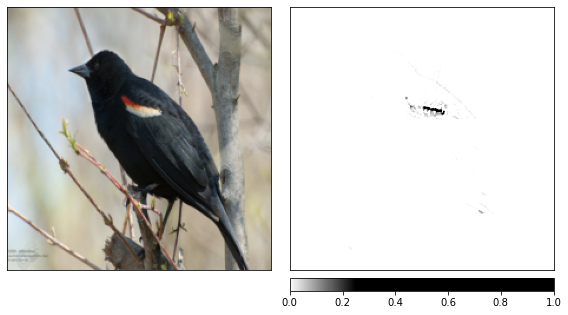

tensor([ 6, 11], device='cuda:0')


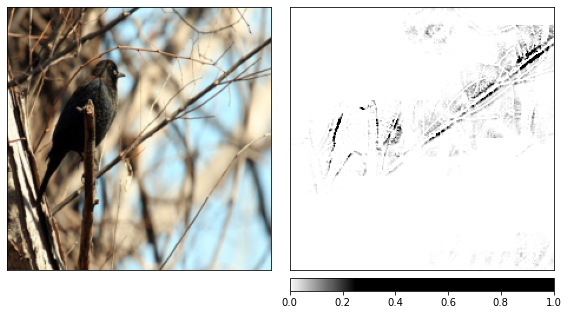

tensor([3, 1], device='cuda:0')


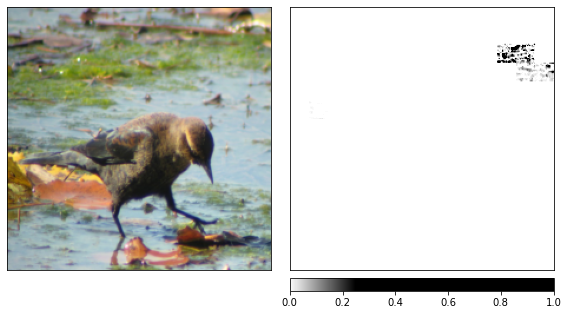

tensor([ 6, 11], device='cuda:0')


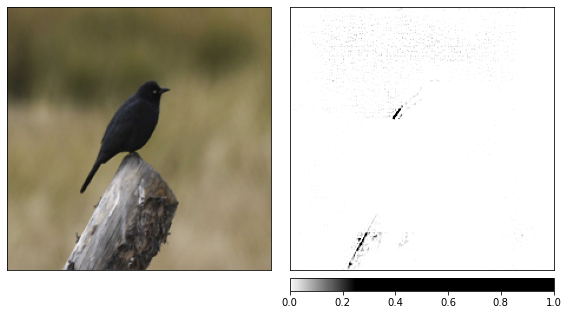

tensor([ 6, 11], device='cuda:0')


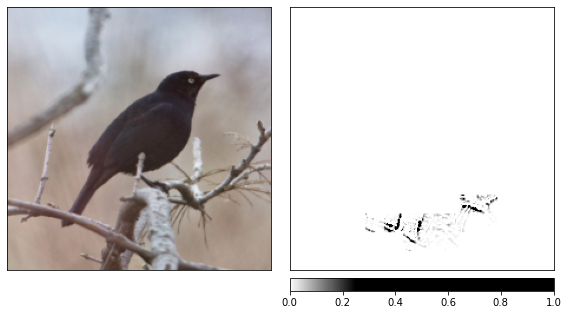

tensor([1, 1], device='cuda:0')


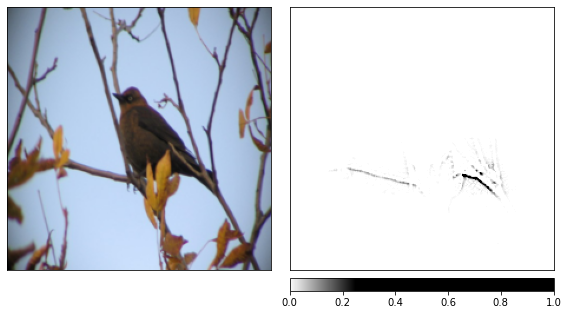

tensor([ 6, 11], device='cuda:0')


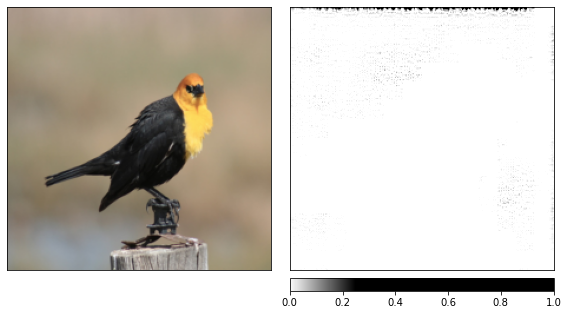

tensor([ 7, 11], device='cuda:0')


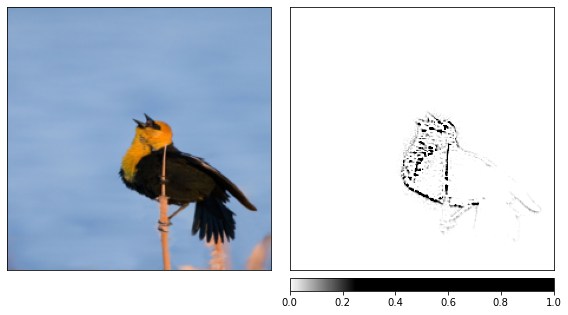

tensor([ 6, 11], device='cuda:0')


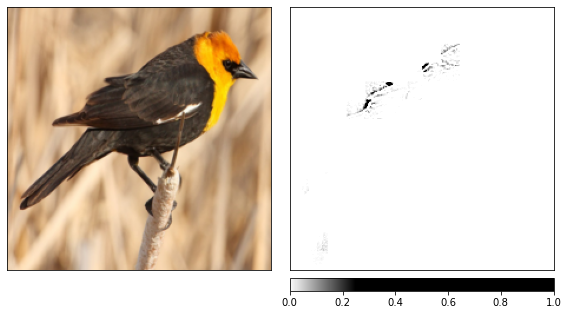

tensor([ 1, 14], device='cuda:0')


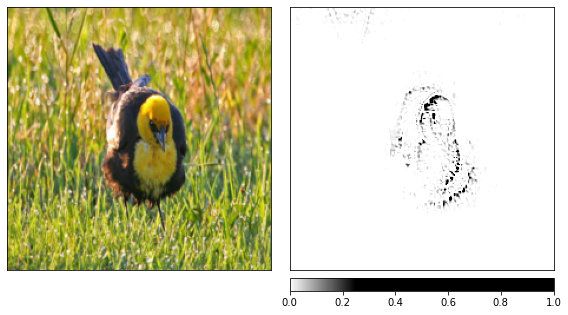

In [24]:
for i in range(10):
    gradCAM_model_multi(model1, i, f'multi-task_bill_shape_{i}')

tensor([ 6, 11], device='cuda:0')


/home/jdlevy/.local/lib/python3.7/site-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/jdlevy/.local/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


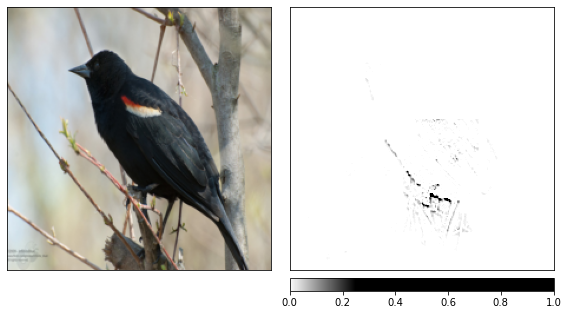

tensor([ 6, 11], device='cuda:0')


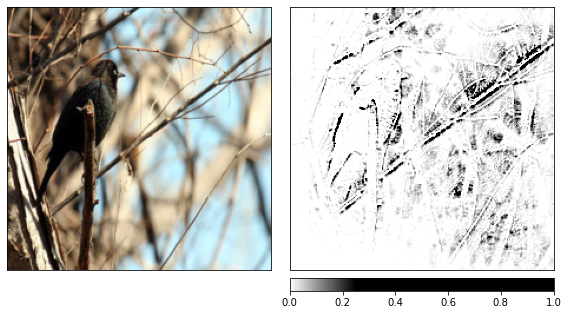

tensor([3, 1], device='cuda:0')


/home/jdlevy/.local/lib/python3.7/site-packages/captum/attr/_utils/visualization.py:45: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  "Attempting to normalize by value approximately 0, visualized results"


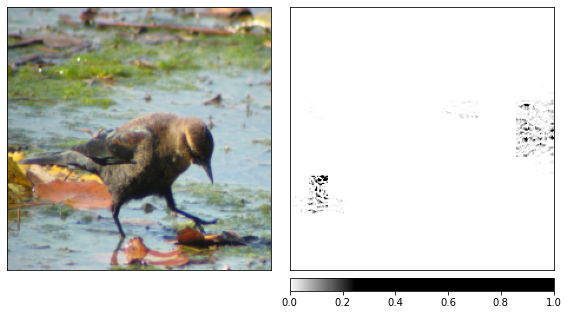

tensor([ 6, 11], device='cuda:0')


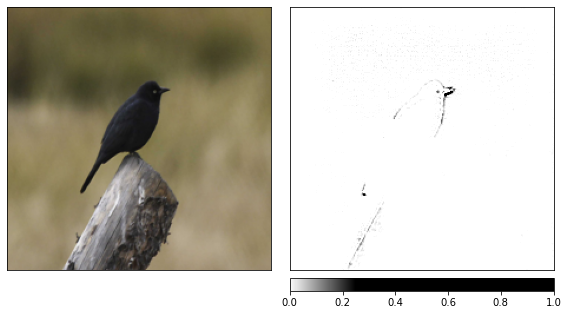

tensor([ 6, 11], device='cuda:0')


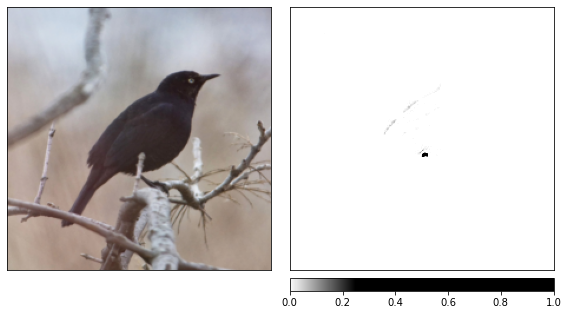

tensor([1, 1], device='cuda:0')


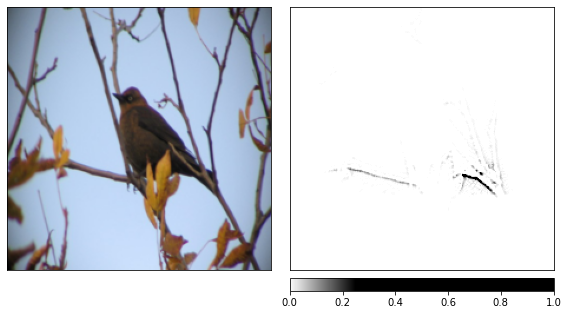

tensor([ 6, 11], device='cuda:0')


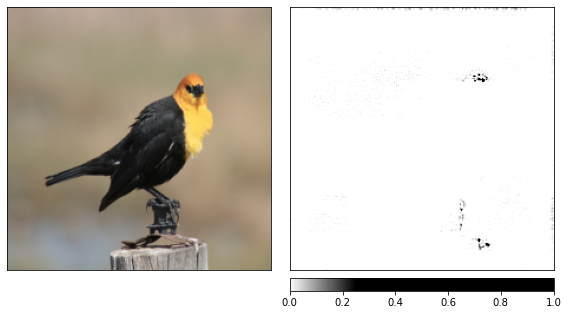

tensor([ 7, 11], device='cuda:0')


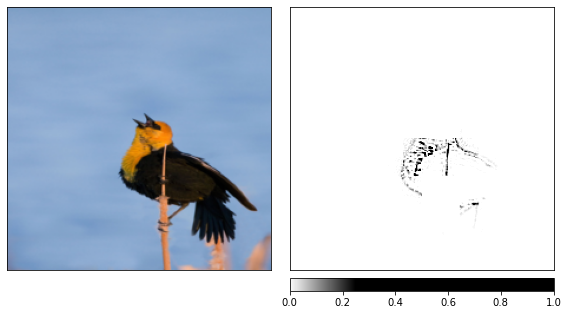

tensor([ 6, 11], device='cuda:0')


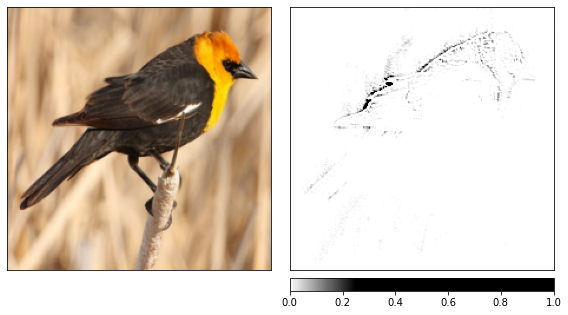

tensor([ 1, 14], device='cuda:0')


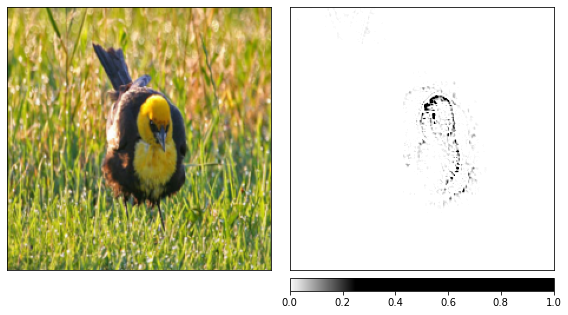

In [23]:
for i in range(10):
    gradCAM_model_multi(model2, i, f'multi-task_wing_color_{i}')

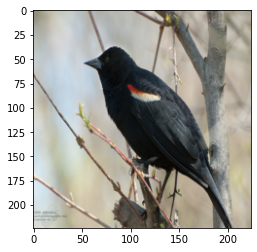

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 3 3, but got 3-dimensional input of size [3, 224, 224] instead

In [95]:
# Check several images.
# dataiter = iter(valloader)
batch_size = 1
# for i in range(len(dataiter)):
# sample = dataiter.next()
sample = val_bird_dataset[0]
images, labels = sample['image'], sample['labels']
imshow(torchvision.utils.make_grid(images))
# print(labels)
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = model(images.to(device))
predicted = [torch.max(i, 1)[1].cpu().numpy()[0] for i in outputs]
# print(f'outputs size: {outputs[1].size()}')
# print(predicted)
print("Ground Truth:", [inv_classes[i][int(labels[i])] for i in range(len(labels))])
print("Predicted:",[inv_classes[i][int(predicted[i])] for i in range(len(labels))])
print("Accuracy:",sum(np.array(labels)==np.array(predicted))/len(labels))

In [93]:
sum(np.array(labels)==np.array(predicted))

2

In [91]:
np.array(labels)

array([ 6, 11])

In [90]:
np.array(predicted)

array([ 6, 11])

In [58]:
int(labels[1])

11

In [56]:
inv_classes

({0: 'has_bill_shape::curved_(up_or_down)',
  1: 'has_bill_shape::dagger',
  2: 'has_bill_shape::hooked',
  3: 'has_bill_shape::needle',
  4: 'has_bill_shape::hooked_seabird',
  5: 'has_bill_shape::spatulate',
  6: 'has_bill_shape::all-purpose',
  7: 'has_bill_shape::cone',
  8: 'has_bill_shape::specialized'},
 {0: 'has_wing_color::blue',
  1: 'has_wing_color::brown',
  2: 'has_wing_color::iridescent',
  3: 'has_wing_color::purple',
  4: 'has_wing_color::rufous',
  5: 'has_wing_color::grey',
  6: 'has_wing_color::yellow',
  7: 'has_wing_color::olive',
  8: 'has_wing_color::green',
  9: 'has_wing_color::pink',
  10: 'has_wing_color::orange',
  11: 'has_wing_color::black',
  12: 'has_wing_color::white',
  13: 'has_wing_color::red',
  14: 'has_wing_color::buff'})